In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

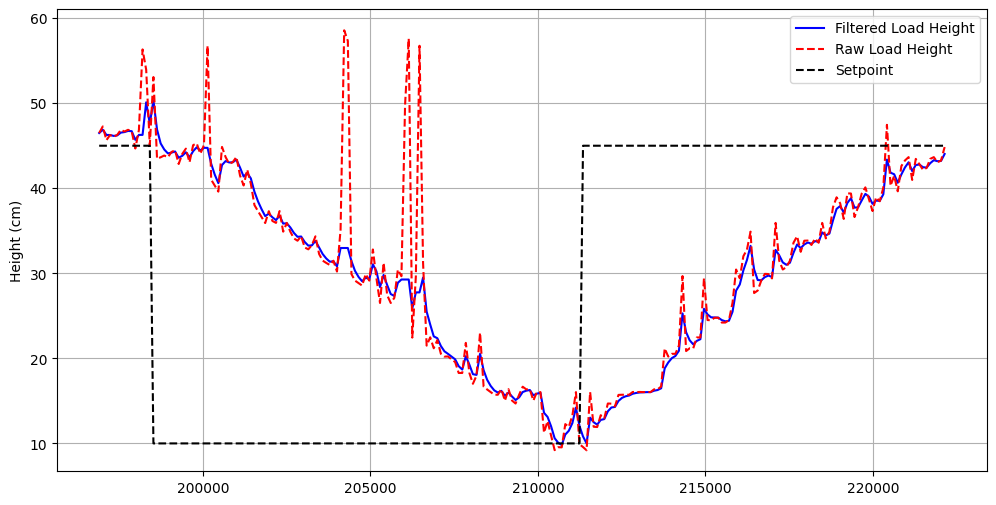

In [90]:
df = pd.read_csv("data.csv").set_index("Time")
height = 0
if height > 0:
    df["Winch Distance"] = height - df["Winch Distance"]
    df["Winch Distance Raw"] = height - df["Winch Distance Raw"]
    # df["Wall Distance"] = height - df["Wall Distance"]
    df["Setpoint"] = height - df["Setpoint"]

plt.figure(figsize = (12, 6))

# the load plot
# plt.subplot(3, 1, 1)
plt.plot(df["Winch Distance"], "b", label = "Filtered Load Height")
plt.plot(df["Winch Distance Raw"], "r--", label = "Raw Load Height")
plt.plot(df["Setpoint"], "k--", label = "Setpoint")
plt.ylabel("Height (cm)")
# plt.ylim(-10, 60)
plt.grid()
plt.legend()

# # the obstacle plot
# plt.subplot(3, 1, 2)
# # plt.plot(df["North Distance"], "r", label = "Front")
# plt.ylabel("Height (cm)")
# plt.ylim(-10, 60)
# plt.grid()
# plt.legend()

# the actuator response plot
# plt.subplot(3, 1, 3)
# plt.plot(df["Winch Action"], "b--", label = "Winch Motor")
# plt.ylabel("Actuator Response")
# plt.grid()
# plt.legend()
# plt.xlabel("Time (s)")

Our system is unique. PID loops can work great in many circumstances, but less great in others. Since our system is an integrating system, the only form of PID is a P-only controller. However, we are limited to the capability of our small DC motors. With only a small amount of power, there is not a wide range of speeds available. Furthermore, the motr, even at its fastest speed, is quite slow. The only thing a PID controller could do is slow down the motor even more. Due to time constraints and practicality, we have opted for an alternate control system, which works as a P-only controller with an infinite gain. Essentially, when the control system detects an error between the setpoint and the measured value, it will turn the actuator on 100% power. 

Disturbance rejection is more applicable. Our primary source of disturbance is sensor noise and load swing. In both scenarios, the sensor reading will spike quite dramatically. To cover this, we have implemented both an alpha filter and outlier rejection. This has successfully smoothed the data to account for these distrubances, even among the variety of setpoints shown above. 

Our source code can be found below:

In [ ]:
from machine import Pin, time_pulse_us
import time

# for disturbance and outlier rejection
class Filtered:

    def __init__(self, threshold = 10, persistance = 3):

        self.threshold = threshold
        self.persistance = persistance
        self.last = None
        self.pending = None
        self.count = 0
        self.values = []
        self.raw = []

    def filter(self, value):

        self.raw.append(value)

        # base case:
        if self.last == None:

            self.last = value

        # edge case
        if value is None:
            return
        
        # the point is an outlier
        if abs(value - self.last) > self.threshold:

            # restart of the outlier is even bigger
            if self.pending is None or abs(value - self.pending) > self.threshold:
                self.pending = value
                self.count = 1
            
            # the outlier seems to be staying
            else:
                self.count += 1

            # the outlier has stayed long enough to be accepted
            if self.count >= self.persistance:
                self.last  = self.pending / 2 + self.last / 2
                self.pending = None
                self.count = 0

        # no outlier
        else:
            self.last = value / 2 + self.last / 2
            self.pending = None
            self.count = 0

        self.values.append(self.last)

    def __getitem__(self, key):
        return self.values[key]
        
TIMES = []
SETPOINTS = []
WINCH_DISTANCES = Filtered()
WALL_DISTANCES = Filtered()
WINCH_ACTIONS = []
SIDE_ACTIONS = []

# sensors
winch_sensor_trig = Pin(27, Pin.OUT)
winch_sensor_echo = Pin(26, Pin.IN)

wall_sensor_trig = Pin(12, Pin.OUT)
wall_sensor_echo = Pin(14, Pin.IN)

# motors
winch_motor_power = Pin(23, Pin.OUT)
winch_motor_up = Pin(21, Pin.OUT)
winch_motor_down = Pin(22, Pin.OUT)

side_motor_power = Pin(5, Pin.OUT)
side_motor_north = Pin(18, Pin.OUT)
side_motor_wall = Pin(19, Pin.OUT)

def test_sensors():

    # test winch sensor
    winch_distance = get_distance_cm(winch_sensor_trig, winch_sensor_echo)
    assert winch_distance is not None, "Winch sensor failed"
    print("Winch sensor passed")
    
    time.sleep(1)

    # test wall sensor
    wall_distance = get_distance_cm(wall_sensor_trig, wall_sensor_echo)
    assert wall_distance is not None, "wall sensor failed"
    print("wall sensor passed")

def get_distance_cm(trig_pin: Pin, echo_pin: Pin, timeout_us=30000):

    # Send 10us trigger pulse
    trig_pin.value(0)
    time.sleep_us(2)
    trig_pin.value(1)
    time.sleep_us(10)
    trig_pin.value(0)

    pulse = time_pulse_us(echo_pin, 1, timeout_us)

    if pulse <= 0:
        # print(pulse)
        return None

    return (pulse / 2) / 29.1  # cm

def winch_up():
    winch_motor_down.off()
    winch_motor_power.on()
    winch_motor_up.on()

def winch_down():
    winch_motor_up.off()
    winch_motor_power.on()
    winch_motor_down.on()

def winch_stop():
    winch_motor_power.off()
    winch_motor_up.off()
    winch_motor_down.off()

def side_stop():
    side_motor_power.off()
    side_motor_north.off()
    side_motor_wall.off()

def move_north():
    side_motor_wall.off()
    side_motor_power.on()
    side_motor_north.on()

def sample(winch_distance, WALL_distance, setpoint = None, side_motor = 0):
    
    TIMES.append(time.ticks_ms())
    SETPOINTS.append(setpoint)
    WINCH_DISTANCES.filter(winch_distance)
    WALL_DISTANCES.filter(WALL_distance)
    SIDE_ACTIONS.append(side_motor)

def to_setpoint(setpoint):

    setpoint = max(10, min(setpoint, 50))

    while True:
        # wait a sec
        time.sleep(0.1)

        # record one sample per loop
        winch_distance = get_distance_cm(winch_sensor_trig, winch_sensor_echo)
        WALL_distance = get_distance_cm(wall_sensor_trig, wall_sensor_echo)
        
        sample(winch_distance, WALL_distance, setpoint)
        if winch_distance is not None and WALL_distance is not None:

            # timeout/no reading: stop motor and log action 0
            if winch_distance <= 0:
                winch_stop()
                WINCH_ACTIONS.append("0")
                # short delay then retry
                time.sleep(0.1)
                continue

            error = setpoint - winch_distance

            if error > 0.25:  # too far
                winch_up()
                WINCH_ACTIONS.append("1")

            elif error < -0.25:  # too close
                winch_down()
                WINCH_ACTIONS.append("-1")

            else:  # at setpoint
                winch_stop()
                WINCH_ACTIONS.append("0")
                break
        
def pass_obstacle(load_height = 7, threshold = 10):

    timer = 0
    found_obstacle = False
    winch_fake = 100
    
    while True:
        # wait a sec
        time.sleep(0.1)

        # measure distances
        winch_distance = get_distance_cm(winch_sensor_trig, winch_sensor_echo)
        WALL_distance = get_distance_cm(wall_sensor_trig, wall_sensor_echo)

        # there is a tall obstacle
        if winch_distance is not None and WALL_distance is not None:
            print("-", end = "")
            if WALL_distance + threshold + load_height < min(winch_distance, winch_fake) and not found_obstacle:
                found_obstacle = True
                winch_fake = WALL_distance - load_height
                sample(winch_distance, WALL_distance, None, 0)
                side_stop()
                to_setpoint(WALL_distance - load_height)

            # there is a valley / we passed over the obstacle
            if found_obstacle:
                timer += 1

            if timer > 70:
                sample(winch_distance, WALL_distance, None, 0)
                side_stop()

                # exit
                break

            # move forward
            else:
                print("moving forward", timer, WALL_distance, winch_distance)
                sample(winch_distance, WALL_distance, None, 1)
                move_north()

def main():
    
    winch_stop()
    side_stop()
    test_sensors()

    try:
        # move_north()
        # time.sleep(1)
        side_stop()
        to_setpoint(45)
        pass_obstacle()
        to_setpoint(45)

    finally:
        string = "Time,Setpoint,Winch Distance,WALL Distance,Winch Action,Side Action\n"
        stringy = []

        def safe_get(container, i):
            try:
                # Filtered implements __getitem__ to access values
                return container[i]
            except Exception:
                try:
                    return container.values[i]
                except Exception:
                    return ""

        # SMOOTH_TIMES = smooth_times(TIMES)

        n = len(TIMES)
        for i in range(n):
            row = [
                safe_get(TIMES, i),
                safe_get(SETPOINTS, i),
                safe_get(WINCH_DISTANCES, i),
                safe_get(WALL_DISTANCES, i),
                safe_get(WINCH_ACTIONS, i),
                safe_get(SIDE_ACTIONS, i)
            ]
            stringy.append(",".join(map(str, row)))

        string += "\n".join(stringy)

        with open("data.csv", "w") as file:
            file.write(string)

def alternate():

    winch_stop()
    side_stop()
    test_sensors()
    
    to_setpoint(45)
    to_setpoint(10)
    to_setpoint(45)

    with open("data.csv", "w") as file:
        file.write( "Time,Setpoint,Winch Distance,Winch Distance Raw,Winch Action\n")

        for thing in zip(TIMES, SETPOINTS, WINCH_DISTANCES.values, WINCH_DISTANCES.raw, WINCH_ACTIONS):

            file.write(",".join(map(str, thing)))
            file.write("\n")


if __name__ == "__main__":

    # alternate()
    main()